<a href="https://colab.research.google.com/github/Haebuk/dataminingTP/blob/main/TermProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 아파트 실거래가 예측

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from tqdm.notebook import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import re

## Data Load

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
test_df = pd.read_csv(PATH + 'test_df_regex.csv')

- exclusive_use_area: 전용면적(한 세대만 독점적으로 사용하는 공간)
- transaction_real_price: 실거래가(단위:만원, 타겟 값, train만 존재)
- transaction_year_month: 거래년월
- transaction_date: 거래일
- floor: 층 

- 데이터가 거래시간 순으로 이루어져 있음

### regex preprocessing
- apt 이름에 존재하는 괄호 + 괄호안 내용 제거

In [ ]:
# 괄호와 괄호안내용 제거
#regex = "\(.*\)|\s-\s.*"
#for i in tqdm(range(len(train_df)), position=0, leave=True):
#    train_df['apt'][i] = re.sub(regex, '', train_df['apt'][i])

# 처리시간이 길어서 과정을 생략하기 위해 따로 csv 파일 생성
# 추후에 로드할 때는 train_df 대신 train_df_regex를 로드함(test도 마찬가지)
#train_df.to_csv('train_df_regex.csv', index=False)


In [ ]:
o_train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현(101동),신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500


## Preprocessing
### Train and Test set

In [ ]:
train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500


In [ ]:
test_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor
0,1145756,10453,서울특별시,목동,938,청학,목동 938 청학,35.55,2002,201711,11~20,2
1,1198704,989,부산광역시,초량동,1143-8,고관맨션,초량동 1143-8 고관맨션,68.72,1977,201708,21~31,2
2,1222384,8597,부산광역시,괴정동,447-13,우림그린,괴정동 447-13 우림그린,72.54,1989,201710,11~20,2


In [ ]:
train_df.describe() 

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price
count,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06,1.216553e+06
mean,6.091530e+05,6.299685e+03,7.816549e+01,1.998297e+03,2.012984e+05,9.343291e+00,3.822769e+04
std,3.526198e+05,3.581169e+03,2.915113e+01,8.941347e+00,2.905732e+02,6.606500e+00,3.104898e+04
min,0.000000e+00,0.000000e+00,9.260000e+00,1.961000e+03,2.008010e+05,-4.000000e+00,1.000000e+02
25%,3.041380e+05,3.345000e+03,5.976000e+01,1.993000e+03,2.010100e+05,4.000000e+00,1.900000e+04
50%,6.082760e+05,5.964000e+03,8.241000e+01,1.999000e+03,2.013120e+05,8.000000e+00,3.090000e+04
75%,9.124140e+05,9.436000e+03,8.497000e+01,2.005000e+03,2.015110e+05,1.300000e+01,4.700000e+04
max,1.234827e+06,1.265800e+04,4.243200e+02,2.017000e+03,2.017110e+05,8.000000e+01,8.200000e+05


In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1216553 entries, 0 to 1216552
Data columns (total 13 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   transaction_id          1216553 non-null  int64  
 1   apartment_id            1216553 non-null  int64  
 2   city                    1216553 non-null  object 
 3   dong                    1216553 non-null  object 
 4   jibun                   1216553 non-null  object 
 5   apt                     1215092 non-null  object 
 6   addr_kr                 1216553 non-null  object 
 7   exclusive_use_area      1216553 non-null  float64
 8   year_of_completion      1216553 non-null  int64  
 9   transaction_year_month  1216553 non-null  int64  
 10  transaction_date        1216553 non-null  object 
 11  floor                   1216553 non-null  int64  
 12  transaction_real_price  1216553 non-null  int64  
dtypes: float64(1), int64(6), object(6)
memory usage: 120.7+ M

- train_df 결측치는 없음
- 1961년 ~ 2017년 완공 건물
- 9.26m^2 ~ 424.32m^2 전용면적
- Floor의 경우 음의 값 존재.
- 실거래가는 100만원부터 820억까지 존재

In [ ]:
train_df.loc[train_df['transaction_real_price']==820000]

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
23603,23603,11320,서울특별시,한남동,810,한남더힐,한남동 810 한남더힐,244.749,2011,201612,21~31,3,820000


In [ ]:
test_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor
count,5.463000e+03,5463.000000,5463.000000,5463.000000,5463.000000,5463.000000
mean,1.167126e+06,6287.570932,79.495250,2000.431082,201710.228446,8.266886
std,4.075365e+04,3624.756304,32.935434,9.982040,2.798195,6.082475
min,1.092791e+06,12.000000,10.321500,1961.000000,201701.000000,-1.000000
25%,1.134296e+06,3278.000000,59.760000,1995.000000,201709.000000,4.000000
50%,1.167937e+06,6091.000000,81.720000,2002.000000,201712.000000,7.000000
75%,1.202560e+06,9416.500000,84.970000,2007.000000,201712.000000,11.000000
max,1.234930e+06,12652.000000,273.860000,2017.000000,201712.000000,55.000000


In [ ]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5463 entries, 0 to 5462
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   transaction_id          5463 non-null   int64  
 1   apartment_id            5463 non-null   int64  
 2   city                    5463 non-null   object 
 3   dong                    5463 non-null   object 
 4   jibun                   5463 non-null   object 
 5   apt                     5463 non-null   object 
 6   addr_kr                 5463 non-null   object 
 7   exclusive_use_area      5463 non-null   float64
 8   year_of_completion      5463 non-null   int64  
 9   transaction_year_month  5463 non-null   int64  
 10  transaction_date        5463 non-null   object 
 11  floor                   5463 non-null   int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 512.3+ KB


### apart

In [ ]:
train_df['apt'].value_counts()[:20]

현대        17716
한신        10135
삼성         6771
대우         6390
신동아        6386
두산         5801
우성         5781
주공2        5669
삼성래미안      5483
벽산         4651
대림         4582
동원로얄듀크     4430
경남         4030
삼환         3896
극동         3771
삼익         3583
롯데캐슬       3570
쌍용         3409
코오롱        3320
한양         3231
Name: apt, dtype: int64

In [ ]:
# 같은 아파트 이름을 갖는 수를 저장하는 apt_counts 열 생성
train_df['apt_counts'] = 0
train_df.groupby('apt')['apt_counts'].count()
train_df = pd.merge(train_df, train_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

test_df['apt_counts'] = 0
test_df.groupby('apt')['apt_counts'].count()
test_df = pd.merge(test_df, test_df.groupby('apt')['apt_counts'].count(), on='apt', how='left').drop('apt_counts_x', axis=1).rename(columns={'apt_counts_y':'apt_counts'})

train_df.head(3)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000,1.0
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500,13.0


In [ ]:
train_df.shape

(1216553, 14)

In [ ]:
train_df['apt'].value_counts()[:10]

현대       17716
한신       10135
삼성        6771
대우        6390
신동아       6386
두산        5801
우성        5781
주공2       5669
삼성래미안     5483
벽산        4651
Name: apt, dtype: int64

- top10 시공사 + 데이터에서 가장 많이 나오는 아파트 20개의 이름을 통일

In [ ]:
train_df['top10'] = 0
test_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

train_df['apt'] = train_df['apt'].fillna('others')
for i, brand in enumerate(top10):
    train_df.loc[train_df['apt'].str.contains(brand), 'top10'] = 1
    test_df.loc[test_df['apt'].str.contains(brand), 'top10'] = 1


In [ ]:
train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price,apt_counts,top10
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500,13.0,0


In [ ]:
apt_names = ['그레이스', '양지', '쌍용', '현대', '한신', '삼성', '대우', '신동아', '두산', '주공',
             '우성', '벽산', '동원로얄듀크','경남', '삼환', '쌍용', '삼익', '대림', '코오롱', '파크리오',
             '엘지', '성원', '잠실', '동궁리치웰', '동성']
apt_names_list = top10 + apt_names

train_df['transformed'] = False
test_df['transformed'] = False

for a in apt_names_list:
    train_df.loc[train_df['apt'].str.contains(a), 'apt'] = a
    test_df.loc[test_df['apt'].str.contains(a), 'apt'] = a
    train_df.loc[train_df['apt'].str.contains(a), 'transformed'] = True
    test_df.loc[test_df['apt'].str.contains(a), 'transformed'] = True

#아파트 이름이 변경되지 않았을 경우 others로 변경
for a in apt_names:
    train_df.loc[~train_df['transformed'], 'apt'] = 'others'
    test_df.loc[~test_df['transformed'] , 'apt'] = 'others'

In [ ]:
train_df['apt'].value_counts()

others          653503
현대               81824
주공               65937
래미안              32743
한신               27481
벽산               26968
우성               24524
롯데캐슬             24053
삼성               20067
sk|SK|에스케이       19709
두산               19501
삼익               18708
푸르지오             18416
쌍용               18256
대림               18194
대우               17786
이편한|e편한|e-편한     14337
신동아              14049
힐스테이트            11985
자이               11719
엘지               10938
경남               10875
코오롱               8602
아이파크              7989
성원                7601
더샵                6977
삼환                6073
동원로얄듀크            6070
파크리오              3094
잠실                2606
동성                2228
데시앙               2222
양지                1033
그레이스               393
동궁리치웰               92
Name: apt, dtype: int64

In [ ]:
print(train_df['apt'].nunique(), test_df['apt'].nunique())

35 35


In [104]:
# 아파트별 가격의 평균 내림차순 정렬, 라벨인코딩
all_df = pd.concat([train_df, test_df], axis=0).reset_index(drop=True)
apt_price = all_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환전\n', apt_price[:5])

for i, a in enumerate(list(apt_price.index)):
    all_df.loc[all_df['apt'] == a, 'apt'] = i
apt_price = all_df.groupby('apt')['transaction_real_price'].agg('mean').sort_values(ascending=False)
print('변환후\n', apt_price[:5])

변환전
 apt
상지리츠빌카일룸2차     530000.000000
트라움하우스3        490000.000000
아펠바움           465860.500000
상지리츠빌카일룸3차     427125.000000
삼성동상지리츠빌카일룸    418992.666667
Name: transaction_real_price, dtype: float64


KeyboardInterrupt: ignored

### date

In [ ]:
# 완공연도에서 최소연도를 뺌으로써 완공연도 라벨인코딩
print('변환전\n', all_df['year_of_completion'].unique()[:5])
all_df['year_of_completion'] = all_df['year_of_completion'] - all_df['year_of_completion'].min()
print('변환후\n', all_df['year_of_completion'].unique()[:5])
# 연월 증가하는 순으로 라벨 인코딩
print('변환전\n', all_df['transaction_year_month'].unique()[:5])
le = LabelEncoder()
all_df['transaction_year_month'] = le.fit_transform(all_df['transaction_year_month'])
print('변환후\n', all_df['transaction_year_month'].unique()[:5])
# 필요없는 열 제거
all_df = all_df.drop(['jibun', 'transaction_date', 'addr_kr'], axis=1)

변환전
 [2002 1973 2007 2003 2004]
변환후
 [41 12 46 42 43]
변환전
 [200801 200802 200803 200804 200805]
변환후
 [0 1 2 3 4]


In [105]:
all_df.head(5)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500.0
1,1,5399,서울특별시,필운동,142,사직파크맨션,필운동 142 사직파크맨션,99.17,1973,200801,1~10,6,20000.0
2,2,3578,서울특별시,필운동,174-1,두레엘리시안,필운동 174-1 두레엘리시안,84.74,2007,200801,1~10,6,38500.0
3,3,10957,서울특별시,내수동,95,401,내수동 95 파크팰리스,146.39,2003,200801,11~20,15,118000.0
4,4,10639,서울특별시,내수동,110-15,345,내수동 110-15 킹스매너,194.43,2004,200801,21~31,3,120000.0


### dong

In [106]:
seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

{'송정동', '사직동', '중동', '부암동'}


- 서울과 부산에 중동, 부암동, 송정동, 사직동이 겹침을 알 수 있음

In [107]:
for d in same_dong:
    all_df.loc[(all_df['city']=='서울특별시') & (all_df['dong']==d), 'dong'] = '서울' + d
    all_df.loc[(all_df['city']=='부산광역시') & (all_df['dong']==d), 'dong'] = '부산' + d

seoul_set = set(all_df.loc[all_df['city']=='서울특별시', 'dong'])
busan_set = set(all_df.loc[all_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)  

set()


- 더 이상 겹치는 동이 없음

In [ ]:
train_df.loc[train_df['dong'].str.contains('장충동')].groupby('dong')['transaction_real_price'].\
agg('mean')

dong
장충동1가    269888.888889
장충동2가      6628.421053
Name: transaction_real_price, dtype: float64

- 같은 동이어도 숫자가 다르면 가격차이가 많이 남
- 따라서 따로 숫자처리를 진행하지 않고 다른 동처럼 취급

In [108]:
dong_price = all_df.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)
dong_price[:41]

dong
장충동1가     269888.888889
압구정동      164534.722914
청암동       161403.700000
용산동5가     153497.331633
회현동2가     139906.140351
반포동       132489.395651
한남동       122593.293264
서빙고동      116547.239777
대치동       116320.538909
남대문로5가    113153.604651
도곡동       110655.655354
청담동       110289.411168
교남동       108600.000000
내수동       107899.014778
주성동       106000.000000
하중동       105900.477833
삼성동       101379.971621
잠실동       101166.337275
동자동        99472.876033
동빙고동       99057.552239
회현동1가      98753.660066
한강로3가      96027.903297
여의도동       93456.214326
서울사직동      93144.310145
이촌동        89409.952902
서교동        88442.874302
견지동        87004.741935
잠원동        86980.647308
방배동        85883.661956
신천동        85334.022796
신계동        84490.522184
자곡동        83905.484615
서초동        83858.755537
한강로1가      82761.069620
원효로1가      81194.484429
방이동        80720.686653
내곡동        79034.412121
상수동        77964.221557
일원동        77417.897626
상왕십리동      77258.186364
신원동        77225.606936
Name: trans

- 동별로 그룹화 후 가격의 평균 계산
- 가격의 평균의 내림차 순으로 정렬

In [ ]:
# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행
for i, d in enumerate(list(dong_price.index)):
    all_df.loc[all_df['dong'] == d, 'dong'] = i
all_df.head()

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10,transformed
0,0,7622,서울특별시,138,23,84.82,41,0,2,37500.0,13.0,0,False
1,1,5399,서울특별시,65,23,99.17,12,0,6,20000.0,1.0,0,False
2,2,3578,서울특별시,65,23,84.74,46,0,6,38500.0,13.0,0,False
3,3,10957,서울특별시,13,23,146.39,42,0,15,118000.0,55.0,0,False
4,4,10639,서울특별시,13,23,194.43,43,0,3,120000.0,15.0,0,False


In [ ]:
all_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.216553e+06,1.220555e+06,1.222016e+06
mean,6.116474e+05,6.299630e+03,7.817144e+01,3.730611e+01,6.461461e+01,9.338479e+00,3.822769e+04,1.351963e+03,1.234329e-01
std,3.538049e+05,3.581363e+03,2.916926e+01,8.947398e+00,3.519266e+01,6.604638e+00,3.104898e+04,2.518944e+03,3.289336e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,-4.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.055038e+05,3.345000e+03,5.976000e+01,3.200000e+01,3.300000e+01,4.000000e+00,1.900000e+04,2.090000e+02,0.000000e+00
50%,6.110075e+05,5.964000e+03,8.240000e+01,3.800000e+01,7.200000e+01,8.000000e+00,3.090000e+04,5.910000e+02,0.000000e+00
75%,9.165112e+05,9.436000e+03,8.497000e+01,4.400000e+01,9.400000e+01,1.300000e+01,4.700000e+04,1.342000e+03,0.000000e+00
max,1.234930e+06,1.265800e+04,4.243200e+02,5.600000e+01,1.190000e+02,8.000000e+01,8.200000e+05,1.771600e+04,1.000000e+00


### Floor

In [ ]:
# 최소값이 -4이므로 4를 더해서 음수를 없애고 순서형범주처리
print('변환전\n', all_df['floor'].values[:5])
all_df['floor'] = all_df['floor'].map(lambda x: x+4)
print('변환후\n', all_df['floor'].values[:5])

변환전
 [ 2  6  6 15  3]
변환후
 [ 6 10 10 19  7]


In [ ]:
all_df.describe()

,transaction_id,apartment_id,exclusive_use_area,year_of_completion,transaction_year_month,floor,transaction_real_price,apt_counts,top10
count,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.216553e+06,1.220555e+06,1.222016e+06
mean,6.116474e+05,6.299630e+03,7.817144e+01,3.730611e+01,6.461461e+01,1.333848e+01,3.822769e+04,1.351963e+03,1.234329e-01
std,3.538049e+05,3.581363e+03,2.916926e+01,8.947398e+00,3.519266e+01,6.604638e+00,3.104898e+04,2.518944e+03,3.289336e-01
min,0.000000e+00,0.000000e+00,9.260000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+02,1.000000e+00,0.000000e+00
25%,3.055038e+05,3.345000e+03,5.976000e+01,3.200000e+01,3.300000e+01,8.000000e+00,1.900000e+04,2.090000e+02,0.000000e+00
50%,6.110075e+05,5.964000e+03,8.240000e+01,3.800000e+01,7.200000e+01,1.200000e+01,3.090000e+04,5.910000e+02,0.000000e+00
75%,9.165112e+05,9.436000e+03,8.497000e+01,4.400000e+01,9.400000e+01,1.700000e+01,4.700000e+04,1.342000e+03,0.000000e+00
max,1.234930e+06,1.265800e+04,4.243200e+02,5.600000e+01,1.190000e+02,8.400000e+01,8.200000e+05,1.771600e+04,1.000000e+00


### Price

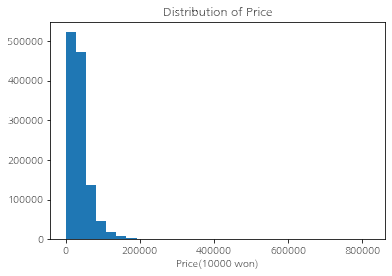

In [ ]:
# train price
plt.figure()
plt.hist(train_df['transaction_real_price'], bins=30)
plt.xlabel('Price(10000 won)')
plt.title('Distribution of Price')
plt.show()

- 가격의 분포가 매우 왼쪽으로 치우친 것을 확인할 수 있음
- 타겟 변수의 이상치가 회귀모형을 사용한 예측에 큰 영향을 줄 수 있음
    - 로그 변환으로 정규화한뒤, 나중에 다시 역변환

In [ ]:
# 가격 로그 변환 후 원래 가격 따로 저장
all_df['log_price'] = np.log1p(all_df['transaction_real_price'])
real_price = all_df['transaction_real_price'] # 원래 가격
#train_y = real_price[:train_df.shape[0]] # train 데이터의 가격
#test_y = real_price[train_df.shape[0]:] # test 데이터의 가격
all_df.drop('transaction_real_price', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,exclusive_use_area,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price
0,0,7622,서울특별시,138,23,84.82,41,0,6,13.0,0,False,10.532123


findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.


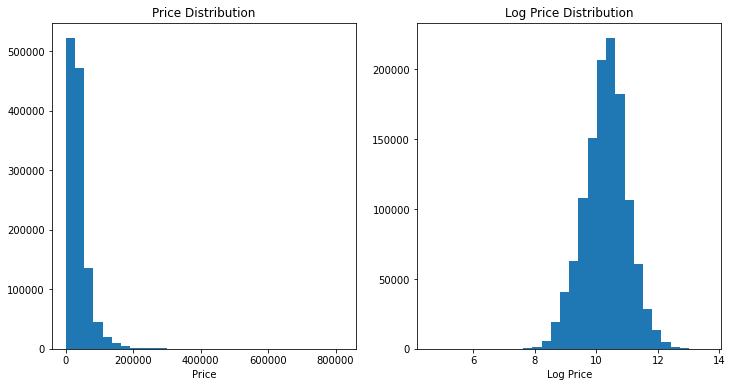

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_df['transaction_real_price'], bins=30)
ax1.set_title('Price Distribution')
ax1.set_xlabel('Price')

ax2.hist(np.log1p(train_df['transaction_real_price']), bins=30)
ax2.set_title('Log Price Distribution')
ax2.set_xlabel('Log Price')

plt.show()

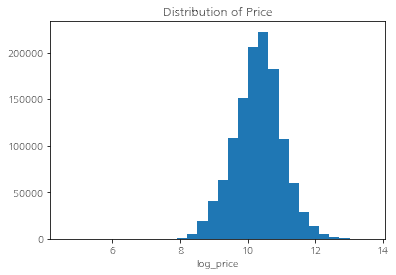

In [ ]:
# train price
plt.figure()
plt.hist(all_df['log_price'], bins=30)
plt.xlabel('log_price')
plt.title('Distribution of Price')
plt.show()

### Area

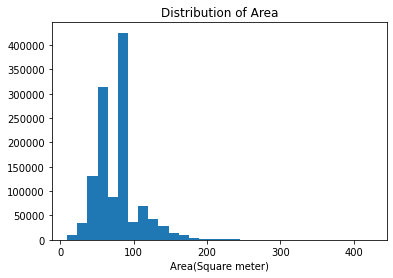

In [ ]:
# train area
plt.figure()
plt.hist(train_df['exclusive_use_area'], bins=30)
plt.xlabel('Area(Square meter)')
plt.title('Distribution of Area')
plt.show()

In [ ]:
# 면적 로그 변환 후 원래 면적 따로 저장
all_df['log_area'] = np.log1p(all_df['exclusive_use_area'])
area = all_df['exclusive_use_area'] # 원래 가격
all_df.drop('exclusive_use_area', axis=1, inplace=True)
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,138,23,41,0,6,13.0,0,False,10.532123,4.452252


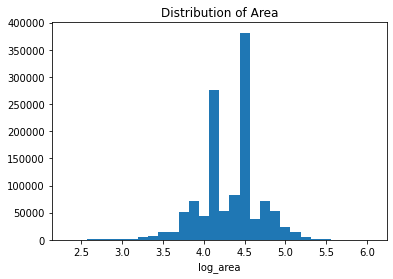

In [ ]:

plt.figure()
plt.hist(all_df['log_area'], bins=30)
plt.xlabel('log_area')
plt.title('Distribution of Area')
plt.show()

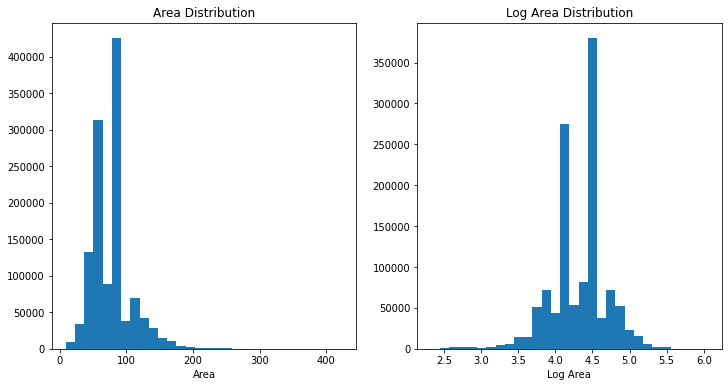

In [ ]:
f, (ax1, ax2) = plt.subplots(1,2,figsize=(12,6))

ax1.hist(train_df['exclusive_use_area'], bins=30)
ax1.set_title('Area Distribution')
ax1.set_xlabel('Area')

ax2.hist(np.log1p(train_df['exclusive_use_area']), bins=30)
ax2.set_title('Log Area Distribution')
ax2.set_xlabel('Log Area')

plt.show()

### Encoding

In [ ]:
ohe_col = ['city']
drop_col = ['transaction_id', 'apartment_id', 'city', 'apt_counts', 'transformed']

ohe_columns = pd.get_dummies(all_df[ohe_col])


In [ ]:
all_df.head(1)

,transaction_id,apartment_id,city,dong,apt,year_of_completion,transaction_year_month,floor,apt_counts,top10,transformed,log_price,log_area
0,0,7622,서울특별시,138,23,41,0,6,13.0,0,False,10.532123,4.452252


In [ ]:
all_df = pd.concat([all_df.drop(drop_col, axis=1), ohe_columns], axis=1)
all_df.head()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,23,41,0,6,0,10.532123,4.452252,0,1
1,65,23,12,0,10,0,9.903538,4.606869,0,1
2,65,23,46,0,10,0,10.558439,4.451319,0,1
3,13,23,42,0,19,0,11.678448,4.993082,0,1
4,13,23,43,0,7,0,11.695255,5.275202,0,1


In [ ]:
all_df.shape

(1222016, 10)

In [ ]:
all_df.to_csv(PATH + 'all_df.csv', index=False)

## 전처리 생략 


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
!pip install https://s3-us-west-2.amazonaws.com/xgboost-nightly-builds/xgboost-1.4.0_SNAPSHOT%2B4224c08cacceba3f83f90e387c07aa6205a83bfa-py3-none-manylinux2010_x86_64.whl
from tqdm import tqdm
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso,  Ridge 
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import  LabelEncoder
from sklearn.model_selection import KFold, cross_val_score, train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import xgboost as xgb
# After running
! git clone --recursive https://github.com/Microsoft/LightGBM
#You can run this oneliner which will build and compile LightGBM with GPU enabled in colab:
! cd LightGBM && rm -rf build && mkdir build && cd build && cmake -DUSE_GPU=1 ../../LightGBM && make -j4 && cd ../python-package && python3 setup.py install --precompile --gpu;    
import lightgbm as lgb
import re
!pip install optuna -q
import optuna
from optuna.integration import XGBoostPruningCallback
from sklearn.externals import joblib
import pickle

import matplotlib as mpl  # 기본 설정 만지는 용도
import matplotlib.pyplot as plt  # 그래프 그리는 용도
import matplotlib.font_manager as fm
!apt-get update -qq
!apt-get install fonts-nanum* -qq
path = '/usr/share/fonts/truetype/nanum/NanumGothicEco.ttf'  # 설치된 나눔글꼴중 원하는 녀석의 전체 경로를 가져오자
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)
fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False

     |████████████████████████████████| 166.7MB 35kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90
Cloning into 'LightGBM'...
remote: Enumerating objects: 22545, done.
remote: Counting objects: 100% (140/140), done.
remote: Compressing objects: 100% (111/111), done.
remote: Total 22545 (delta 68), reused 46 (delta 26), pack-reused 22405
Receiving objects: 100% (22545/22545), 17.53 MiB | 3.35 MiB/s, done.
Resolving deltas: 100% (16523/16523), done.
Submodule 'include/boost/compute' (https://github.com/boostorg/compute) registered for path 'external_libs/compute'
Submodule 'eigen' (https://gitlab.com/libeigen/eigen.git) registered for path 'external_libs/eigen'
Submodule 'external_libs/fast_double_parser' (https://github.com/lemire/fast_double_parser.git) registered for path 'external_libs/fast_double_parser'
Submodule 'external_libs/fmt' (https://github.com/fmtlib/fmt.git) registered for path 'external_libs/fmt'

/usr/local/lib/python3.7/dist-packages/sklearn/externals/joblib/__init__.py:15: FutureWarning:

sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.



Selecting previously unselected package fonts-nanum.
(Reading database ... 160772 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumGothic Eco


In [156]:
PATH = '/content/drive/MyDrive/input/dataminingTP/'
train_df = pd.read_csv(PATH + 'train_df_regex.csv')
all_df = pd.read_csv(PATH + 'all_df.csv')
all_df = all_df.drop('apt', axis=1)

In [157]:
all_df.head()

,dong,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,41,0,6,0,10.532123,4.452252,0,1
1,65,12,0,10,0,9.903538,4.606869,0,1
2,65,46,0,10,0,10.558439,4.451319,0,1
3,13,42,0,19,0,11.678448,4.993082,0,1
4,13,43,0,7,0,11.695255,5.275202,0,1


In [164]:
all_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1222016 entries, 0 to 1222015
Data columns (total 9 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   dong                    1222016 non-null  int64  
 1   year_of_completion      1222016 non-null  int64  
 2   transaction_year_month  1222016 non-null  int64  
 3   floor                   1222016 non-null  int64  
 4   top10                   1222016 non-null  int64  
 5   log_price               1216553 non-null  float64
 6   log_area                1222016 non-null  float64
 7   city_부산광역시              1222016 non-null  int64  
 8   city_서울특별시              1222016 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 83.9 MB


In [ ]:
all_df.describe()

,dong,apt,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
count,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.222016e+06,1.216553e+06,1.222016e+06,1.222016e+06,1.222016e+06
mean,2.407773e+02,2.036411e+01,3.730611e+01,6.461461e+01,1.333848e+01,1.234329e-01,1.030509e+01,4.306129e+00,3.893730e-01,6.106270e-01
std,1.267679e+02,6.551806e+00,8.947398e+00,3.519266e+01,6.604638e+00,3.289336e-01,7.054740e-01,3.688630e-01,4.876083e-01,4.876083e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.615121e+00,2.328253e+00,0.000000e+00,0.000000e+00
25%,1.300000e+02,1.700000e+01,3.200000e+01,3.300000e+01,8.000000e+00,0.000000e+00,9.852247e+00,4.106932e+00,0.000000e+00,0.000000e+00
50%,2.580000e+02,2.300000e+01,3.800000e+01,7.200000e+01,1.200000e+01,0.000000e+00,1.033854e+01,4.423648e+00,0.000000e+00,1.000000e+00
75%,3.380000e+02,2.300000e+01,4.400000e+01,9.400000e+01,1.700000e+01,0.000000e+00,1.075792e+01,4.453998e+00,1.000000e+00,1.000000e+00
max,4.760000e+02,3.400000e+01,5.600000e+01,1.190000e+02,8.400000e+01,1.000000e+00,1.361706e+01,6.052842e+00,1.000000e+00,1.000000e+00


In [158]:
train_df = all_df[:train_df.shape[0]]
train_y = train_df['log_price']
train_X = train_df.drop('log_price', axis=1)
test_df = all_df[train_df.shape[0]:].drop('log_price', axis=1)
print(train_df.shape, test_df.shape, train_X.shape, train_y.shape)

(1216553, 9) (5463, 8) (1216553, 8) (1216553,)


In [5]:
train_X.head(1)

,dong,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
0,138,41,0,6,0,4.452252,0,1


In [6]:
train_y.head(1)

0    10.532123
Name: log_price, dtype: float64

In [159]:
train_df.head(1)

,dong,year_of_completion,transaction_year_month,floor,top10,log_price,log_area,city_부산광역시,city_서울특별시
0,138,41,0,6,0,10.532123,4.452252,0,1


In [160]:
test_df.head(1)

,dong,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
1216553,51,41,118,6,0,3.598681,0,1



## Modeling

### Linear Regression

In [9]:
reg = LinearRegression().fit(train_X, train_y)
reg.score(train_X, train_y) # R^2

0.84983133093988

- wo_apt: 0.8498313309398801
- apt: 0.8498336379444464

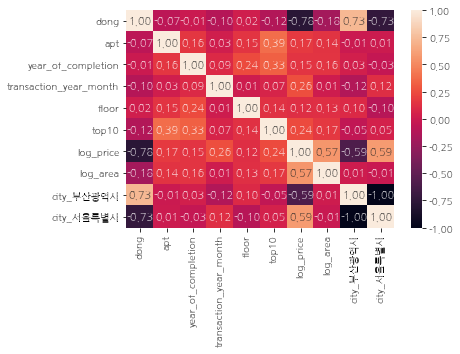

In [ ]:
sns.heatmap(train_df.corr(), annot=True, fmt='.2f', annot_kws={"fontsize":11})
plt.show()

### Set RMSE Score

In [10]:
def RMSE(y, y_pred):
    rmse = mean_squared_error(y, y_pred) ** 0.5
    return rmse

def rmse_cv(model):
    tscv = TimeSeriesSplit(n_splits=10)
    rmse_list = []
    for i, (train_index, test_index) in enumerate(tscv.split(train_X), start=1):
        X_train, X_test = train_X.iloc[train_index], train_X.iloc[test_index]
        y_train, y_test = train_y.iloc[train_index], train_y.iloc[test_index]
        clf = model.fit(X_train, y_train)
        pred = clf.predict(X_test)
        rmse = RMSE(y_test, pred) 
        rmse_list.append(rmse)
    return type(model).__name__, rmse_list

def print_rmse_score(model):
    model_name, score = rmse_cv(model)
    for i, r in tqdm(enumerate(score, start=1), leave=True):
        if i == 1:
            print('\n')
            print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
        else:
            print(f'{i} FOLDS: {model_name} RMSLE: {r:.4f}')
    print(f'\n{model_name} mean RMSLE: {np.mean(score):.4f}')
    print('='*40)

In [11]:
ridge = Ridge(alpha=0.8, random_state=1)
lasso = Lasso(alpha = 0.01, random_state=1)
Enet = ElasticNet(alpha=0.03, l1_ratio=0.01, random_state=1)

# DTree의 스코어가 가장 높았으므로 DTree 부터 시작
DTree = DecisionTreeRegressor(max_depth=6, min_samples_split=10, min_samples_leaf=15, random_state=1)
rf = RandomForestRegressor(n_estimators=500, criterion='mse', max_depth=9, min_samples_split=50,
                           min_samples_leaf=5, random_state=1)
model_xgb = xgb.XGBRegressor(colsample_bytree=0.4603, gamma=0.0468, learning_rate=0.05,
                             max_depth=3, min_child_weight=1.7817, n_estimators=1000,
                             reg_alpha=0.4640, reg_lambda=0.8571, subsample=0.5213,
                             silent=1, random_state=1, nthread=-1)
model_lgb = lgb.LGBMRegressor(objective='regression', num_leaves=5, learning_rate=0.05, 
                              n_estimators=720, max_bin=55, bagging_fraction=0.8,
                              bagging_freq=5, feature_fraction=0.2319, feature_fraction_seed=9,
                              bagging_seed=9, min_data_in_leaf=6, min_sum_hessian_in_leaf=11)

In [ ]:
score = []
for model in [reg, ridge, lasso, Enet, DTree]:
    print_rmse_score(model)

10it [00:00, 2316.02it/s]




1 FOLDS: LinearRegression RMSE: 0.1970
2 FOLDS: LinearRegression RMSE: 0.2509
3 FOLDS: LinearRegression RMSE: 0.2142
4 FOLDS: LinearRegression RMSE: 0.3582
5 FOLDS: LinearRegression RMSE: 0.3423
6 FOLDS: LinearRegression RMSE: 0.3490
7 FOLDS: LinearRegression RMSE: 0.3382
8 FOLDS: LinearRegression RMSE: 0.2909
9 FOLDS: LinearRegression RMSE: 0.2620
10 FOLDS: LinearRegression RMSE: 0.2850

LinearRegression mean RMSE: 0.2888


10it [00:00, 1848.93it/s]




1 FOLDS: Ridge RMSE: 0.1970
2 FOLDS: Ridge RMSE: 0.2509
3 FOLDS: Ridge RMSE: 0.2142
4 FOLDS: Ridge RMSE: 0.3582
5 FOLDS: Ridge RMSE: 0.3423
6 FOLDS: Ridge RMSE: 0.3490
7 FOLDS: Ridge RMSE: 0.3382
8 FOLDS: Ridge RMSE: 0.2909
9 FOLDS: Ridge RMSE: 0.2620
10 FOLDS: Ridge RMSE: 0.2850

Ridge mean RMSE: 0.2888


10it [00:00, 918.05it/s]




1 FOLDS: Lasso RMSE: 0.1993
2 FOLDS: Lasso RMSE: 0.2505
3 FOLDS: Lasso RMSE: 0.2148
4 FOLDS: Lasso RMSE: 0.3627
5 FOLDS: Lasso RMSE: 0.3373
6 FOLDS: Lasso RMSE: 0.4183
7 FOLDS: Lasso RMSE: 0.3587
8 FOLDS: Lasso RMSE: 0.3056
9 FOLDS: Lasso RMSE: 0.2639
10 FOLDS: Lasso RMSE: 0.2792

Lasso mean RMSE: 0.2990


10it [00:00, 1501.88it/s]




1 FOLDS: ElasticNet RMSE: 0.2063
2 FOLDS: ElasticNet RMSE: 0.2532
3 FOLDS: ElasticNet RMSE: 0.2177
4 FOLDS: ElasticNet RMSE: 0.3678
5 FOLDS: ElasticNet RMSE: 0.3343
6 FOLDS: ElasticNet RMSE: 0.3701
7 FOLDS: ElasticNet RMSE: 0.3572
8 FOLDS: ElasticNet RMSE: 0.3053
9 FOLDS: ElasticNet RMSE: 0.2678
10 FOLDS: ElasticNet RMSE: 0.2805

ElasticNet mean RMSE: 0.2960


10it [00:00, 26083.98it/s]



1 FOLDS: DecisionTreeRegressor RMSE: 0.1892
2 FOLDS: DecisionTreeRegressor RMSE: 0.2700
3 FOLDS: DecisionTreeRegressor RMSE: 0.2172
4 FOLDS: DecisionTreeRegressor RMSE: 0.3591
5 FOLDS: DecisionTreeRegressor RMSE: 0.3873
6 FOLDS: DecisionTreeRegressor RMSE: 0.3512
7 FOLDS: DecisionTreeRegressor RMSE: 0.3719
8 FOLDS: DecisionTreeRegressor RMSE: 0.3128
9 FOLDS: DecisionTreeRegressor RMSE: 0.2985
10 FOLDS: DecisionTreeRegressor RMSE: 0.3348

DecisionTreeRegressor mean RMSE: 0.3092


In [ ]:
for model in [rf, model_xgb, model_lgb]:
    print_rmse_score(model)

In [ ]:
score = [0.2888, 0.2888, 0.2990, 0.2960, 0.3102, 0.2749, 0.2390, 0.2419]
model = ['Linear Regression', 'Ridge', 'Lasso', "ElasticNet", 'DecisionTree','RandomForest', 'XGBoost', 'LightGBM']

result_df = pd.DataFrame({'Model': model, 'Score': score}).sort_values(by='Score', ascending=True).reset_index(drop=True)
result_df.head(8)


,Model,Score
0,XGBoost,0.2300
1,LightGBM,0.2340
2,RandomForest,0.2749
3,Linear Regression,0.2871
4,Ridge,0.2871
5,ElasticNet,0.2941
6,Lasso,0.2977
7,DecisionTree,0.3100


In [ ]:
- wo_apt: score = [0.2886, 0.2886, 0.2998, 0.2958, 0.3102, 0.2749, 0.2390, 0.2419]
- apt: 

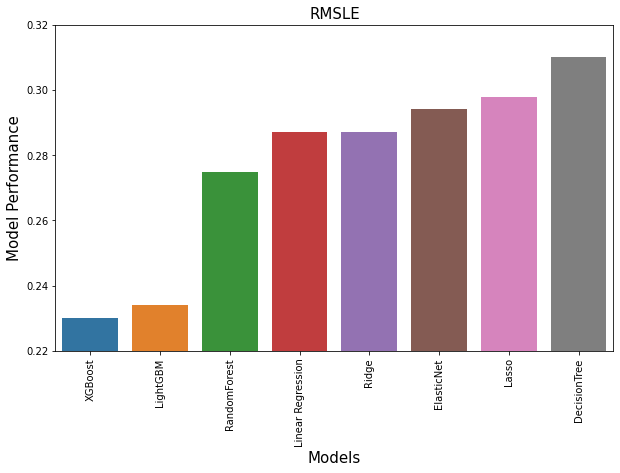

In [ ]:
f, ax = plt.subplots(figsize=(10, 6))
plt.xticks(rotation='90')
sns.barplot(x=result_df['Model'], y=result_df['Score'])
plt.xlabel('Models', fontsize=15)
plt.ylabel('Model Performance', fontsize=15)
plt.ylim(0.22, 0.32)
plt.title('RMSLE', fontsize=15)
plt.show()

- xgboost 하이퍼 파라미터 튜닝 진행

### Hyperparameter Tuning

In [12]:
cut = int(len(train_df)*0.8)
h_train = train_df[:cut]
h_valid = train_df[cut:]

h_train_X = h_train.drop('log_price', axis=1)
h_train_y = h_train['log_price']
h_valid_X = h_valid.drop('log_price', axis=1)
h_valid_y = h_valid['log_price']
print(h_train_X.shape, h_train_y.shape, h_valid_X.shape, h_valid_y.shape)

(973242, 8) (973242,) (243311, 8) (243311,)


In [13]:
h_train_X.head()

,dong,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
0,138,41,0,6,0,4.452252,0,1
1,65,12,0,10,0,4.606869,0,1
2,65,46,0,10,0,4.451319,0,1
3,13,42,0,19,0,4.993082,0,1
4,13,43,0,7,0,5.275202,0,1


#### XGBoost optuna

In [14]:
from optuna.samplers import TPESampler

sampler = TPESampler(seed=10)
n_repeats=3

def objective(trial):
    dtrain = xgb.DMatrix(h_train_X, label=h_train_y)
    dtest = xgb.DMatrix(h_valid_X, label=h_valid_y)

    param = {
        'objective': 'reg:squarederror', # 회귀
         'eval_metric': 'rmse',
         "xgb_gpu_hist": 1,
         'verbosity': 0,
         'booster': 'gbtree', # gradient boosting decision tree
         'lambda': trial.suggest_loguniform('lambda', 1e-8, 1),
         'alpha': trial.suggest_loguniform('alpha', 1e-8, 1),
         'max_depth': trial.suggest_int('max_depth',3, 9),
         'learning_rate': 0.01,
         "eta": trial.suggest_loguniform("eta", 1e-8, 1.0),
         "gamma": trial.suggest_loguniform("gamma", 1e-8, 1.0),
         'n_estimators': trial.suggest_int('n_estimators', 700, 1500),
         'min_child_weight': trial.suggest_int('min_child_weight', 0, 10),
         'subsample': trial.suggest_loguniform('subsample', 0.4, 1)
    }

    model = xgb.XGBRegressor(**param)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    xgb_2 = model.fit(h_train_X, h_train_y, eval_set=[(h_valid_X, h_valid_y)], verbose=0,
                      eval_metric='rmse', callbacks=[pruning_callback])

    rmse = RMSE(h_valid_y, xgb_2.predict(h_valid_X))
    return rmse
        
study_xgb = optuna.create_study(direction='minimize', sampler=sampler)
study_xgb.optimize(objective, n_trials=50)

[I 2021-06-22 11:41:50,234] A new study created in memory with name: no-name-ec80f1a8-cacf-4179-b2b8-5f62eea32fa7
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-22 11:47:48,803] Trial 0 finished with value: 0.20655606098580012 and parameters: {'lambda': 0.014810344004555135, 'alpha': 1.4656004675652718e-08, 'max_depth': 7, 'eta': 0.00978207662259244, 'gamma': 9.728728830009641e-05, 'n_estimators': 880, 'min_child_weight': 2, 'subsample': 0.8029815922829752}. Best is trial 0 with value: 0.20655606098580012.
/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption

[I 2021-06-22 11:55:23,488] Trial 1 finished with value: 0.20419357744162184 and parameters: {'lambda': 2.253651157496

In [16]:
print('Best Trial: score {},\nparams {}'.format(study_xgb.best_trial.value, study_xgb.best_trial.params))

Best Trial: score 0.20019178035912613,
params {'lambda': 2.2741802872089376e-05, 'alpha': 0.00029229369026373484, 'max_depth': 9, 'eta': 0.05598548865779304, 'gamma': 0.005501346075473814, 'n_estimators': 1181, 'min_child_weight': 10, 'subsample': 0.4150834316309578}


In [17]:
optuna.visualization.plot_param_importances(study_xgb)

## XGBoost Submission

In [18]:
trial = study_xgb.best_trial
xgb_params = trial.params
xgb_params

{'alpha': 0.00029229369026373484,
 'eta': 0.05598548865779304,
 'gamma': 0.005501346075473814,
 'lambda': 2.2741802872089376e-05,
 'max_depth': 9,
 'min_child_weight': 10,
 'n_estimators': 1181,
 'subsample': 0.4150834316309578}

In [19]:
final_xgb_model = xgb.XGBRegressor(**xgb_params)
final_xgb_model.fit(train_X, train_y, eval_metric='rmse')
final_xgb_pred = final_xgb_model.predict(test_df)

/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [20]:
final_xgb_pred

array([10.310147 ,  9.4687805,  9.453366 , ..., 10.989199 , 10.569776 ,
        9.7787075], dtype=float32)

<BarContainer object of 8 artists>

findfont: Font family ['NanumGothic Eco'] not found. Falling back to DejaVu Sans.
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 48512 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49328 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 44305 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 50669 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49884 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 49436 missing from current font.

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning:

Glyph 

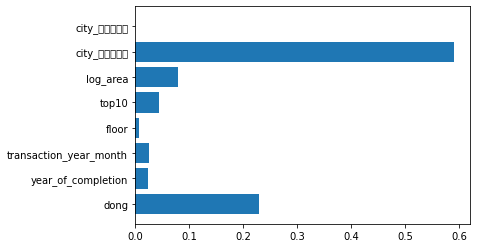

In [21]:
plt.barh(train_X.columns, final_xgb_model.feature_importances_)

In [22]:
final_pred_sub = np.expm1(final_xgb_pred)
final_pred_sub

array([30034.86 , 12948.086, 12750.017, ..., 59229.902, 38938.934,
       17652.82 ], dtype=float32)

In [23]:
sub = pd.read_csv(PATH + 'test.csv')
sub_df = pd.DataFrame({'transaction_id': sub['transaction_id'], 'transaction_real_price': final_pred_sub})
sub_df

,transaction_id,transaction_real_price
0,1145756,30034.859375
1,1198704,12948.085938
2,1222384,12750.016602
3,1179897,118555.234375
4,1223091,45606.089844
...,...,...
5458,1174640,69404.226562
5459,1175575,197598.281250
5460,1157024,59229.902344
5461,1136863,38938.933594


In [24]:
sub_df.to_csv(PATH + 'submission_xgb_wo_apt2.csv', index=False)

## Extra Predict
- 공공데이터를 이용하여 추가로 분석

In [170]:
o_train_df = pd.read_csv(PATH + 'train_df_regex.csv')
o_test_df = pd.read_csv(PATH + 'test_df_regex.csv')
o_train_df.head(1)

,transaction_id,apartment_id,city,dong,jibun,apt,addr_kr,exclusive_use_area,year_of_completion,transaction_year_month,transaction_date,floor,transaction_real_price
0,0,7622,서울특별시,신교동,6-13,신현,신교동 6-13 신현(101동),84.82,2002,200801,21~31,2,37500


In [188]:
extra_df = pd.read_csv(PATH + 'extra_test_data.csv')
extra_df.head()

,city,dong,apt,exclusive_use_area,transaction_year,transaction_real_price,floor,year_of_completion,Unnamed: 8
0,서울특별시,개포동,개포6차우성아파트1동~8동,79.97,120,130000,4,1987,NaN
1,서울특별시,개포동,성원대치2단지아파트,39.53,121,88400,10,1992,NaN
2,서울특별시,대치동,한보미도맨션2,115.05,123,228000,13,1985,NaN
3,서울특별시,대치동,한티,102.43,125,96700,4,2004,NaN
4,서울특별시,대치동,해암프리존,204.38,120,140000,4,1996,NaN


### top10

In [189]:
extra_df['top10'] = 0
top10 = ['자이', '푸르지오', '더샵', '롯데캐슬', '이편한|e편한|e-편한',
         '힐스테이트', '아이파크', '래미안', 'sk|SK|에스케이', '데시앙']

for i, brand in enumerate(top10):
    extra_df.loc[extra_df['apt'].str.contains(brand), 'top10'] = 1

### city

In [190]:
extra_df['city_서울특별시'] = 0
extra_df['city_부산광역시'] = 0
extra_df.loc[extra_df['city'] == '서울특별시', 'city_서울특별시'] = 1
extra_df.head(1)

,city,dong,apt,exclusive_use_area,transaction_year,transaction_real_price,floor,year_of_completion,Unnamed: 8,top10,city_서울특별시,city_부산광역시
0,서울특별시,개포동,개포6차우성아파트1동~8동,79.97,120,130000,4,1987,NaN,0,1,0


### date

In [191]:
# transaction_year는 이미 진행
extra_df['year_of_completion'] -= 1961
extra_df.head(1)

,city,dong,apt,exclusive_use_area,transaction_year,transaction_real_price,floor,year_of_completion,Unnamed: 8,top10,city_서울특별시,city_부산광역시
0,서울특별시,개포동,개포6차우성아파트1동~8동,79.97,120,130000,4,26,NaN,0,1,0


### dong

In [192]:
seoul_set = set(extra_df.loc[extra_df['city']=='서울특별시', 'dong'])
busan_set = set(extra_df.loc[extra_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong)

for d in same_dong:
    if False:
        pass
    else:
        extra_df.loc[(extra_df['city']=='서울특별시') & (extra_df['dong']==d), 'dong'] = '서울' + d
        extra_df.loc[(extra_df['city']=='부산광역시') & (extra_df['dong']==d), 'dong'] = '부산' + d

seoul_set = set(extra_df.loc[extra_df['city']=='서울특별시', 'dong'])
busan_set = set(extra_df.loc[extra_df['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set
print(same_dong) 

set()
set()


In [193]:
all_df2 = pd.concat([o_train_df, o_test_df], axis=0).reset_index(drop=True)

seoul_set = set(all_df2.loc[all_df2['city']=='서울특별시', 'dong'])
busan_set = set(all_df2.loc[all_df2['city']=='부산광역시', 'dong'])
same_dong = seoul_set & busan_set 
print(same_dong)

for d in same_dong:
    all_df2.loc[(all_df2['city']=='서울특별시') & (all_df2['dong']==d), 'dong'] = '서울' + d
    all_df2.loc[(all_df2['city']=='부산광역시') & (all_df2['dong']==d), 'dong'] = '부산' + d

dong_price = all_df2.groupby('dong')['transaction_real_price'].agg('mean').sort_values(ascending=False)

# 가격기준으로 동을 정렬한 리스트를 바탕으로 dong에 대해 라벨 인코딩 진행
for i, d in enumerate(list(dong_price.index)):
    extra_df.loc[extra_df['dong'] == d, 'dong'] = i


{'송정동', '사직동', '중동', '부암동'}


### floor

In [194]:
extra_df['floor'] += 4

### price, area

In [195]:
extra_df['log_price'] = np.log1p(extra_df['transaction_real_price'])
extra_df['log_area'] = np.log1p(extra_df['exclusive_use_area'])
extra_df.head(1)

,city,dong,apt,exclusive_use_area,transaction_year,transaction_real_price,floor,year_of_completion,Unnamed: 8,top10,city_서울특별시,city_부산광역시,log_price,log_area
0,서울특별시,41,개포6차우성아파트1동~8동,79.97,120,130000,8,26,NaN,0,1,0,11.775297,4.394079


### drop

In [196]:
real_price = extra_df['transaction_real_price']
extra_df.drop(['city', 'apt', 'exclusive_use_area', 'Unnamed: 8', 'transaction_real_price'], axis=1, inplace=True)
extra_df


,dong,transaction_year,floor,year_of_completion,top10,city_서울특별시,city_부산광역시,log_price,log_area
0,41,120,8,26,0,1,0,11.775297,4.394079
1,41,121,14,31,0,1,0,11.389639,3.702042
2,8,123,17,24,0,1,0,12.337105,4.754021
3,8,125,8,43,0,1,0,11.479379,4.638895
4,8,120,8,35,0,1,0,11.849405,5.324862
5,8,122,8,29,0,1,0,11.674202,4.445823
6,8,127,12,29,0,1,0,11.904974,4.445823
7,8,128,6,29,0,1,0,11.931642,4.445823
8,8,121,11,55,0,1,0,11.082158,3.916812
9,8,123,10,55,0,1,0,10.783135,3.529004


In [203]:
extra_df.to_csv(PATH + 'extra_df_final.csv', index=False)

In [204]:
extra_df2 = pd.read_csv(PATH + 'extra_df_final.csv')

In [206]:
extra_df2

,dong,transaction_year,floor,year_of_completion,top10,city_서울특별시,city_부산광역시,log_price,log_area
0,41,120,8,26,0,1,0,11.775297,4.394079
1,41,121,14,31,0,1,0,11.389639,3.702042
2,8,123,17,24,0,1,0,12.337105,4.754021
3,8,125,8,43,0,1,0,11.479379,4.638895
4,8,120,8,35,0,1,0,11.849405,5.324862
5,8,122,8,29,0,1,0,11.674202,4.445823
6,8,127,12,29,0,1,0,11.904974,4.445823
7,8,128,6,29,0,1,0,11.931642,4.445823
8,8,121,11,55,0,1,0,11.082158,3.916812
9,8,123,10,55,0,1,0,10.783135,3.529004


In [205]:
extra_df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   dong                11 non-null     int64  
 1   transaction_year    11 non-null     int64  
 2   floor               11 non-null     int64  
 3   year_of_completion  11 non-null     int64  
 4   top10               11 non-null     int64  
 5   city_서울특별시          11 non-null     int64  
 6   city_부산광역시          11 non-null     int64  
 7   log_price           11 non-null     float64
 8   log_area            11 non-null     float64
dtypes: float64(2), int64(7)
memory usage: 920.0 bytes


### 예측

In [208]:
extra_predict_log = final_xgb_model.predict(extra_df2.drop('log_price', axis=1))
extra_predict_exp = np.expm1(extra_predict_log)
print(RMSE(real_price, extra_predict_exp))
print(RMSE(np.log1p(real_price), extra_predict_log))

111075.80914935649
1.8920496604357162


/usr/local/lib/python3.7/dist-packages/xgboost/data.py:114: UserWarning:

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption



In [209]:
print(real_price)
print(extra_predict_exp)
print(np.log1p(real_price))
print(extra_predict_log)

0     130000
1      88400
2     228000
3      96700
4     140000
5     117500
6     148000
7     152000
8      65000
9      48200
10     67919
Name: transaction_real_price, dtype: int64
[16815.758 16676.76  16558.133 17145.72  16866.225 16680.56  15863.19
 16591.504 17978.535 18240.105 17978.535]
0     11.775297
1     11.389639
2     12.337105
3     11.479379
4     11.849405
5     11.674202
6     11.904974
7     11.931642
8     11.082158
9     10.783135
10    11.126086
Name: transaction_real_price, dtype: float64
[9.730131 9.721831 9.714693 9.749562 9.733128 9.722059 9.67182  9.716706
 9.796989 9.811433 9.796989]


In [210]:
test_df

,dong,year_of_completion,transaction_year_month,floor,top10,log_area,city_부산광역시,city_서울특별시
1216553,51,41,118,6,0,3.598681,0,1
1216554,417,16,115,6,0,4.244487,1,0
1216555,409,28,117,6,0,4.297829,1,0
1216556,8,43,114,14,0,4.723309,0,1
1216557,415,53,119,25,1,4.792809,1,0
...,...,...,...,...,...,...,...,...
1222011,97,42,117,11,0,4.443239,0,1
1222012,5,48,119,8,1,4.453533,0,1
1222013,274,43,119,27,1,4.711222,0,1
1222014,223,44,117,5,0,4.537320,0,1
